In [1]:
import seaborn as sns
import numpy as np
import scipy.stats as stats
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from fs import methods as m
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt





# %% [code]
# %% [code]
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 16 10:51:57 2020
This library can be used to find clusters of collinear variable in a larger data set and replace them with principal component(s) of the cluster. There is option to visualize the collinear relationship within a cluster.

@author: Nasseh Khodaie
"""
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA

class cluster():
    def __init__(self, pairs=None):
        '''
        Pairs = list of tuple e.g. [(node1,node2, weight1),(node3,node4,weight2)]
        '''
        self.pairs = set()
        self.nodes = set()
        self.name = None
        if pairs != None:
            for pair in pairs:
                self.nodes.update([pair[0],pair[1]])
                self.pairs.add(pair)

    def update_with(self, pair, force_update = False):
        if force_update:
            self.nodes.update([pair[0],pair[1]])
            self.pairs.add(pair)
        else:    
            if self.can_accept(pair):
                self.nodes.update([pair[0],pair[1]])
                self.pairs.add(pair)
            else:
                raise Exception(f'The pair {pair} can not be added to this cluster because it does not have any shared node with the current cluster nodes.')
        
    def can_accept(self, pair):
        return (pair[0] in self.nodes or pair[1] in self.nodes)
    
    def merge_with_cluster(self, cluster2, force_merge = False):
        def merge():
            self.nodes = self.nodes.union(cluster2.nodes)
            self.pairs = self.pairs.union(cluster2.pairs)
        
        if force_merge:
            merge()
        else:    
            if self.nodes.intersection(cluster2.nodes) != set():
                merge()
            else:
                raise Exception(f'The clusters can not be merged because they do not have any common node.')

    def plot(self, fig_size = (10,10), dpi= 200, max_line_width = 5, min_line_width = 1, min_alpha = 0.2, threshold=None, font_size=20):
        if threshold == None:
            threshold = min([pair[2] for pair in self.pairs])
        graph_pairs = [(pair[0],pair[1]) for pair in self.pairs]
        graph = nx.Graph()
        plt.figure(figsize = fig_size, dpi = dpi)
        graph.add_edges_from(graph_pairs)
        pos = nx.spring_layout(graph)

        for pair in self.pairs:
            nx.draw_networkx_nodes(graph, pos, node_size=300, edgecolors = (0.3,0.3,0.3), linewidths = 1, node_color = '#FFF')

            alph = (abs(pair[2])-threshold)/(1-threshold)
            if alph < min_alpha:
                alph = min_alpha
#            print(pair[2])

            w = (abs(pair[2])-threshold)/(1-threshold)*max_line_width
            if w < min_line_width:
                w = min_line_width

            color = 'b'    
            if pair[2]<0:
                color = 'r'

            nx.draw_networkx_edges(graph, pos, edge_color = color, edgelist = [[pair[0],pair[1]]], width = w, alpha = alph )
            nx.draw_networkx_labels(graph, pos, font_size=font_size, font_weight = 'bold', font_family='sans-serif', font_color=(0,0,0), alpha = 0.9)
            nx.draw_networkx_edge_labels(graph, pos, self.pairs)

        plt.title(self.name)

def identify_cluster(X_data_df, threshold = 0.7, correlation_id_method = 'pearson'):
    cor = X_data_df.corr(method = correlation_id_method)

    clusters = []
    for j,col in enumerate (cor.columns):
        for i,row in enumerate (cor.columns[0:j]):
            if abs(cor.iloc[i,j])>threshold:
                current_pair = (col,row, cor.iloc[i,j])
                current_pair_added = False
                for _c in clusters:
                    if _c.can_accept(current_pair):
                        _c.update_with(current_pair)
                        current_pair_added = True
                if current_pair_added == False:
                    clusters.append(cluster(pairs = [current_pair]))
    final_clusters = []
    for _cluster in clusters:
        added_to_final = False
        for final_c in final_clusters:
            if _cluster.nodes.intersection(final_c.nodes) != set():
                final_c.merge_with_cluster(_cluster)
                added_to_final = True
        if added_to_final == False:
            final_clusters.append(_cluster)
    for i, _cluster in enumerate(final_clusters):
        _cluster.name = f'cluster_{i}'
    return final_clusters



def _pca(X_data,n=1):
#    pc_explained_variance = []
#    pc_components = []
    pca = PCA(n_components = n, svd_solver = 'auto')
    pca.fit(X_data)
    X_pca = pca.transform(X_data)
#    print(pca.explained_variance_ratio_ , sum(pca.explained_variance_ratio_ ))
#    for i in range (n):
#        pc_explained_variance.append(pca.explained_variance_)
#        pc_components.append(pca.components_)        
    return (X_pca ,pca.explained_variance_ratio_, pca.components_, pca)               


class collinear_data():
    def __init__ (self, collinear_df):
        self.collinear_df = collinear_df
#        self._clusters = self.clusters(threshold = 0.7)
#        self.cluster_variables = {cl.name:cl.nodes for cl in self._clusters}
        self.pca_obj_dict = None
        
    def clusters(self, threshold = 0.7):
        self._clusters = identify_cluster(self.collinear_df , threshold = threshold)
        self.cluster_variables = {cl.name:cl.nodes for cl in self._clusters}
        for _cl in self._clusters:
            setattr(self,_cl.name, _cl)

    
    def _add_pc_to_collin_df(self, raw_data_df, pc_data, cluster_name, column_to_drop):
        raw_data = raw_data_df.copy()
        for i in range(pc_data.shape[1]):
            raw_data[f'{cluster_name}_pc{i}'] = pc_data[:,i]
        raw_data = raw_data.drop(column_to_drop, axis = 1)
        return raw_data
        
    def non_collinear_df(self, threshold = 0.5, min_total_variance_ratio_explained = 0.9, verbose = True):
        self.clusters(threshold=threshold)
        final_df = self.collinear_df.copy()
#        conversion_dict={}
        pca_obj_dict = {}
#        cluster_linearity_index_dict={}
        for cluster_ in self._clusters:
#            print ('**',len(cluster_.nodes))
            for num_component in range(1,len(cluster_.nodes)): 
                pc_data, expl_variance, component, pca_obj = _pca(self.collinear_df[cluster_.nodes], n=num_component)
                if sum(expl_variance) > min_total_variance_ratio_explained:
                    break
            if verbose:
                print ('*'*10)
                print (cluster_.name)
                print (f'feature name = {str(cluster_.nodes)[1:-1]}')
                print (f'number of PC needed = {len(expl_variance)}')
                for i , variance in enumerate(expl_variance):
                    print (f'explained variance by PC_{i} = {variance}')
#            print ('Super_param shape is: ', pc_data.shape)
#            cluster_linearity_index_dict[cluster_.name] = expl_variance[0]/expl_variance[1]
#            final_df = final_df.drop(cluster_.nodes, axis = 1)
#            for i in range(pc_data.shape[1]):
#                final_df[f'{cluster_.name}_pc{i}'] = pc_data[:,i]
            
            final_df = self._add_pc_to_collin_df(final_df, pc_data, cluster_.name,cluster_.nodes)
#            conversion_dict[cluster_.name] = pd.Series(component[0][0], index = cluster_.nodes)
            pca_obj_dict[cluster_.name]  = pca_obj
#        self.conversion_dict = conversion_dict
        self.pca_obj_dict = pca_obj_dict
#        self.cluster_collinearity_index= cluster_linearity_index_dict

        return final_df
    
    def convert_new_collin_data(self, sample_collin_df):
        '''
        Converts a dataframe containing collinear variables to the \
        non_collinear version that can be used with the non_collinear \
        training set. This function is meant to be used after the clusters \
        are identified so first run non_collinear_df method to identify 
        clusters and create conversion_dict.
        '''
        final_result = sample_collin_df.copy()
#        if self.conversion_dict == None:
#            raise Exception ("'conversion_dict' missing. Please run 'non_collinear_df' method first.")
#        for cl in  self._clusters:
#            final_result[cl.name] = (point_ds[self.conversion_dict[cl.name].index]*self.conversion_dict[cl.name]).sum()
#            final_result = final_result.drop(list(self.conversion_dict[cl.name].index)) #drop does not work
#        return final_result
        if self.pca_obj_dict == None:
            raise Exception ("'conversion_dict' missing. Please run 'non_collinear_df' method first.")
        for cl in  self._clusters:
            collin_data = final_result[cl.nodes]
            pc_data = self.pca_obj_dict[cl.name].transform(collin_data)
            final_result = self._add_pc_to_collin_df(final_result, pc_data, cl.name, cl.nodes)
#            
#            
#            final_result[cl.name] = (point_ds[self.conversion_dict[cl.name].index]*self.conversion_dict[cl.name]).sum()
#            final_result = final_result.drop(list(self.conversion_dict[cl.name].index)) #drop does not work
        return final_result
def sample_data(file):
    return pd.read_csv(file, index_col = 'Time')




'''if __name__ == '__main__':
    raw_data = sample_data('../input/sample-multicollinear-data/sample_X_data.csv')
# =============================================================================
# We should first define a threshold for identifying collinear pairs. Two 
# variables are collinear if their abs(Pearson correlation parameter) > threshold.    
# =============================================================================
  
    thresh = 0.7

# =============================================================================
# You can identify the clusters and  visualize them with graphs without 
# doing any processing. Uncomment he next three lines if you want to do so.    
# =============================================================================
#    clusters = identify_cluster(raw_data, threshold = thresh)
#    for cl in clusters:
#        cl.plot()

# =============================================================================
# Now the normal way of using this library. First create a collinear_data 
# object by providing the raw data which is a Pandas dataframe.
# =============================================================================

    collin_data = collinear_data(raw_data)

# =============================================================================
# Let's create a non-collinear version of the data set. Under the hood,this is
# done by first identifying collinear pairs of variables, then clustering the
# the collinear pairs that share a varaible. Finally, principal component (PC)  
# of the cluster will be calculated and replace the cluster variables in the 
# original data set. The number of PC used to represent the cluster is 
# determined by the minimum amount variance ration needed to be explained by
# by the PCs combined. By default, enough PCs will be added to explain 90% of
# variance. Minimum explained variance ratio can be changed if needed.
# =============================================================================
    
    non_collin_data = collin_data.non_collinear_df(threshold = thresh, \
                                                   min_total_variance_ratio_explained = 0.9)

# =============================================================================
# You can visualize the identified clusters this way
# =============================================================================
    for cl in collin_data._clusters:
        cl.plot()

# =============================================================================
# Let's say now you have made a ML model using the non-collinear data and you 
# want to testa new data point which is in the collinear format.
# You have to conver the collinear data point first to make sure your new data 
# point has the same number of features as the treated data used to make the ML 
# model. This is how you can do this
# =============================================================================
        
    point_coll = pd.DataFrame(raw_data.iloc[2,:]).T #example of a collinear data point
    point_non_collin = collin_data.convert_new_collin_data(point_coll)
    print (f'non-collinear training dataset shape = {non_collin_data.shape}')
    print ( f'collinear point shape = {point_coll.shape} ')
    print ( f'non-collinear point shape = {point_non_collin.shape} ')

# I look forward to hearing your feedback. email me: nassehk@gmail.com
        
'''





pd.set_option('display.max_rows', 500)
#Periods
geopackages = ['0324_0331_2021','0418_0425_2021', '0717_0724_2021','0903_0910_2021','1007_1014_2021']

#Configuration
params = ['0_1_mountains', '0_1_nomountains', '0_01_mountains', '0_01_nomountains']
timestamps = [m.get_tuple(i) for i in geopackages]

target = 'pm25_st'
value_th = 0.1
#List of labels from which are selected the '_st' variable
labels = list(gpd.read_file('assets/grids_0_1/grid_0_1_'+ geopackages[0]+'.gpkg').dropna(axis=0).dropna(axis=1).columns)
method_list = ['Pearson', 'Spearmanr', 'Kendall', 'Fisher', 'RF Importance', 'RFS']
var_t = 'empty'
target_labels = []
dictionary_results = {}
dataframes_results = {}
labels_list = []
resolutions = []
NUMBER_OF_COVARIATES = 20
timestamps = (timestamps - np.mean(timestamps) / np.std(timestamps))

for par in params:

    data_tot = pd.DataFrame()
    Y_tot = []
    for index, grid in enumerate(geopackages):
        #Data acquisition depending of the resolution
        if(par[0:3] == '0_1'):
            data = gpd.read_file('assets/grids_0_1/grid_0_1_'+ grid+'.gpkg')
            data = m.process_data(data, 10, target)
        else:
            data = gpd.read_file('assets/grids_0_01/grid_0_01_'+ grid+'.gpkg')
            data = m.process_data(data, 30, target)

        #PreAlpes and Alpes are filtered depending on the configuration
        data.pop('geometry')
        if(par[-11:]=='nomountains'):
            data = data[data['clim_zone'] > 3]
        data.pop('clim_zone')
        data['time']= timestamps[index]#m.get_tuple(grid)
        data_tot = pd.concat([data_tot,data])

    data = pd.DataFrame(data_tot)
    data = data[~data[target].isnull()]
    data = data.dropna(axis=1).dropna(axis=0)
    labels = data.columns
    score_results = pd.DataFrame()
    X = pd.DataFrame(data=data, columns=labels )
    y = pd.DataFrame(X[target])
    Y = y.values.ravel()
    X.pop(target)
    X.pop('lat_cen')
    X.pop('lng_cen')
    scores_th = m.quasi_zero_variance(X, 20, 0.2)
    for i, label in enumerate(scores_th['Features']):
        if scores_th['Scores'].tolist()[i] != 1:
            X = X.drop(label, 1)
    times = X['time']
    y['time'] = times

    X.pop('time')
    #Data trasformation
    X = X.apply(stats.zscore)
    X = X.dropna(axis=1)
    Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

    labels = X.columns.tolist()
    labels_list.append(labels)
    score_results['Features'] = labels
    raw_data = collinear_data(X)
    treated_data = raw_data.non_collinear_df(threshold = 0.8,
                                         min_total_variance_ratio_explained=0,
                                         verbose = True)
    X_new = raw_data.convert_new_collin_data(X)
    score_results = m.fs_results_computation(X_new, Y)

    #Before borda count execution filter methods results are replaced by its absolute value since we are interested in both positive and negative correlation
    s = score_results.copy()
    s['Pearson'] = s['Pearson'].abs()
    s['Kendall'] = s['Kendall'].abs()
    s['Spearmanr'] = s['Spearmanr'].abs()
    score_results['Borda Count Voting'] = m.borda_voting(s)
    #this commented code is used to export results fro each different period
    #score_results.to_excel('assets/fs_results/'+par+grid+'out.xls')
    #score_results.to_csv('assets/fs_results/'+par+grid+'out.csv')
    plt.figure()
    for index, cl in enumerate(raw_data._clusters):
        cl.plot(fig_size = (10,6),dpi = 200, font_size = 7).savefig(par+cl.name+'.png')
    
    labels_selected = score_results.sort_values('Borda Count Voting',ascending = False)['Features'].tolist()[:NUMBER_OF_COVARIATES]
    print('New features: ',X_new.columns)
    print('Features selected: ', labels_selected)
    X_fs = pd.DataFrame(X_new, columns=labels_selected)
    X_fs['time'] = times
    Y_test = y[y['time']>=timestamps[4]]
    Y_test.pop('time')
    Y_test.values.ravel()
    Y_train= y[y['time']<timestamps[4]]
    Y_train.pop('time')
    Y_train.values.ravel()

    X_train = X_fs[X_fs['time']<timestamps[4]]
    X_test = X_fs[X_fs['time']>=timestamps[4]]
    X_fs=X_fs.to_numpy()

    regressor1 = RandomForestRegressor(n_estimators=300)
    regressor1.fit(X_train, Y_train)
    y_pred = regressor1.predict(X_test)
    mae = mean_absolute_error(Y_test, y_pred)
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)

    print(par)
    print('---------VALIDATION (WITH FS)  ---------')
    print('Mean Absolute Error: ',mae)
    print('Root Mean Squared Error: ',np.sqrt(mse))
    print('Mean Squared Error: ',mse)
    print('R2 score: ',r2)
    print('\n')
    for i in range(0,5):
        print('Test number: ', i)
        X_no_fs = X_new.sample(n=NUMBER_OF_COVARIATES,axis='columns')
        X_no_fs['time'] = times
        X_train = X_no_fs[X_no_fs['time']<timestamps[4]]
        X_test = X_no_fs[X_no_fs['time']>=timestamps[4]]
        X_no_fs=X_no_fs.to_numpy()

        regressor2 = None
        regressor2 = RandomForestRegressor(n_estimators=300)

        regressor2.fit(X_train, Y_train)

        y_pred2 = regressor1.predict(X_test)


        mae = mean_absolute_error(Y_test, y_pred2)
        mse = mean_squared_error(Y_test, y_pred2)
        r2 = r2_score(Y_test, y_pred2)

        print('---------VALIDATION (WITHOUT FS)  ---------')
        print('Mean Absolute Error: ',mae)
        print('Root Mean Squared Error: ',np.sqrt(mse))
        print('Mean Squared Error: ',mse)
        print('R2 score: ',r2)
    print('\n\n\n\n')




SyntaxError: invalid syntax (1678818365.py, line 379)

Text(0.5, 1.0, 'Correlation Heatmap')

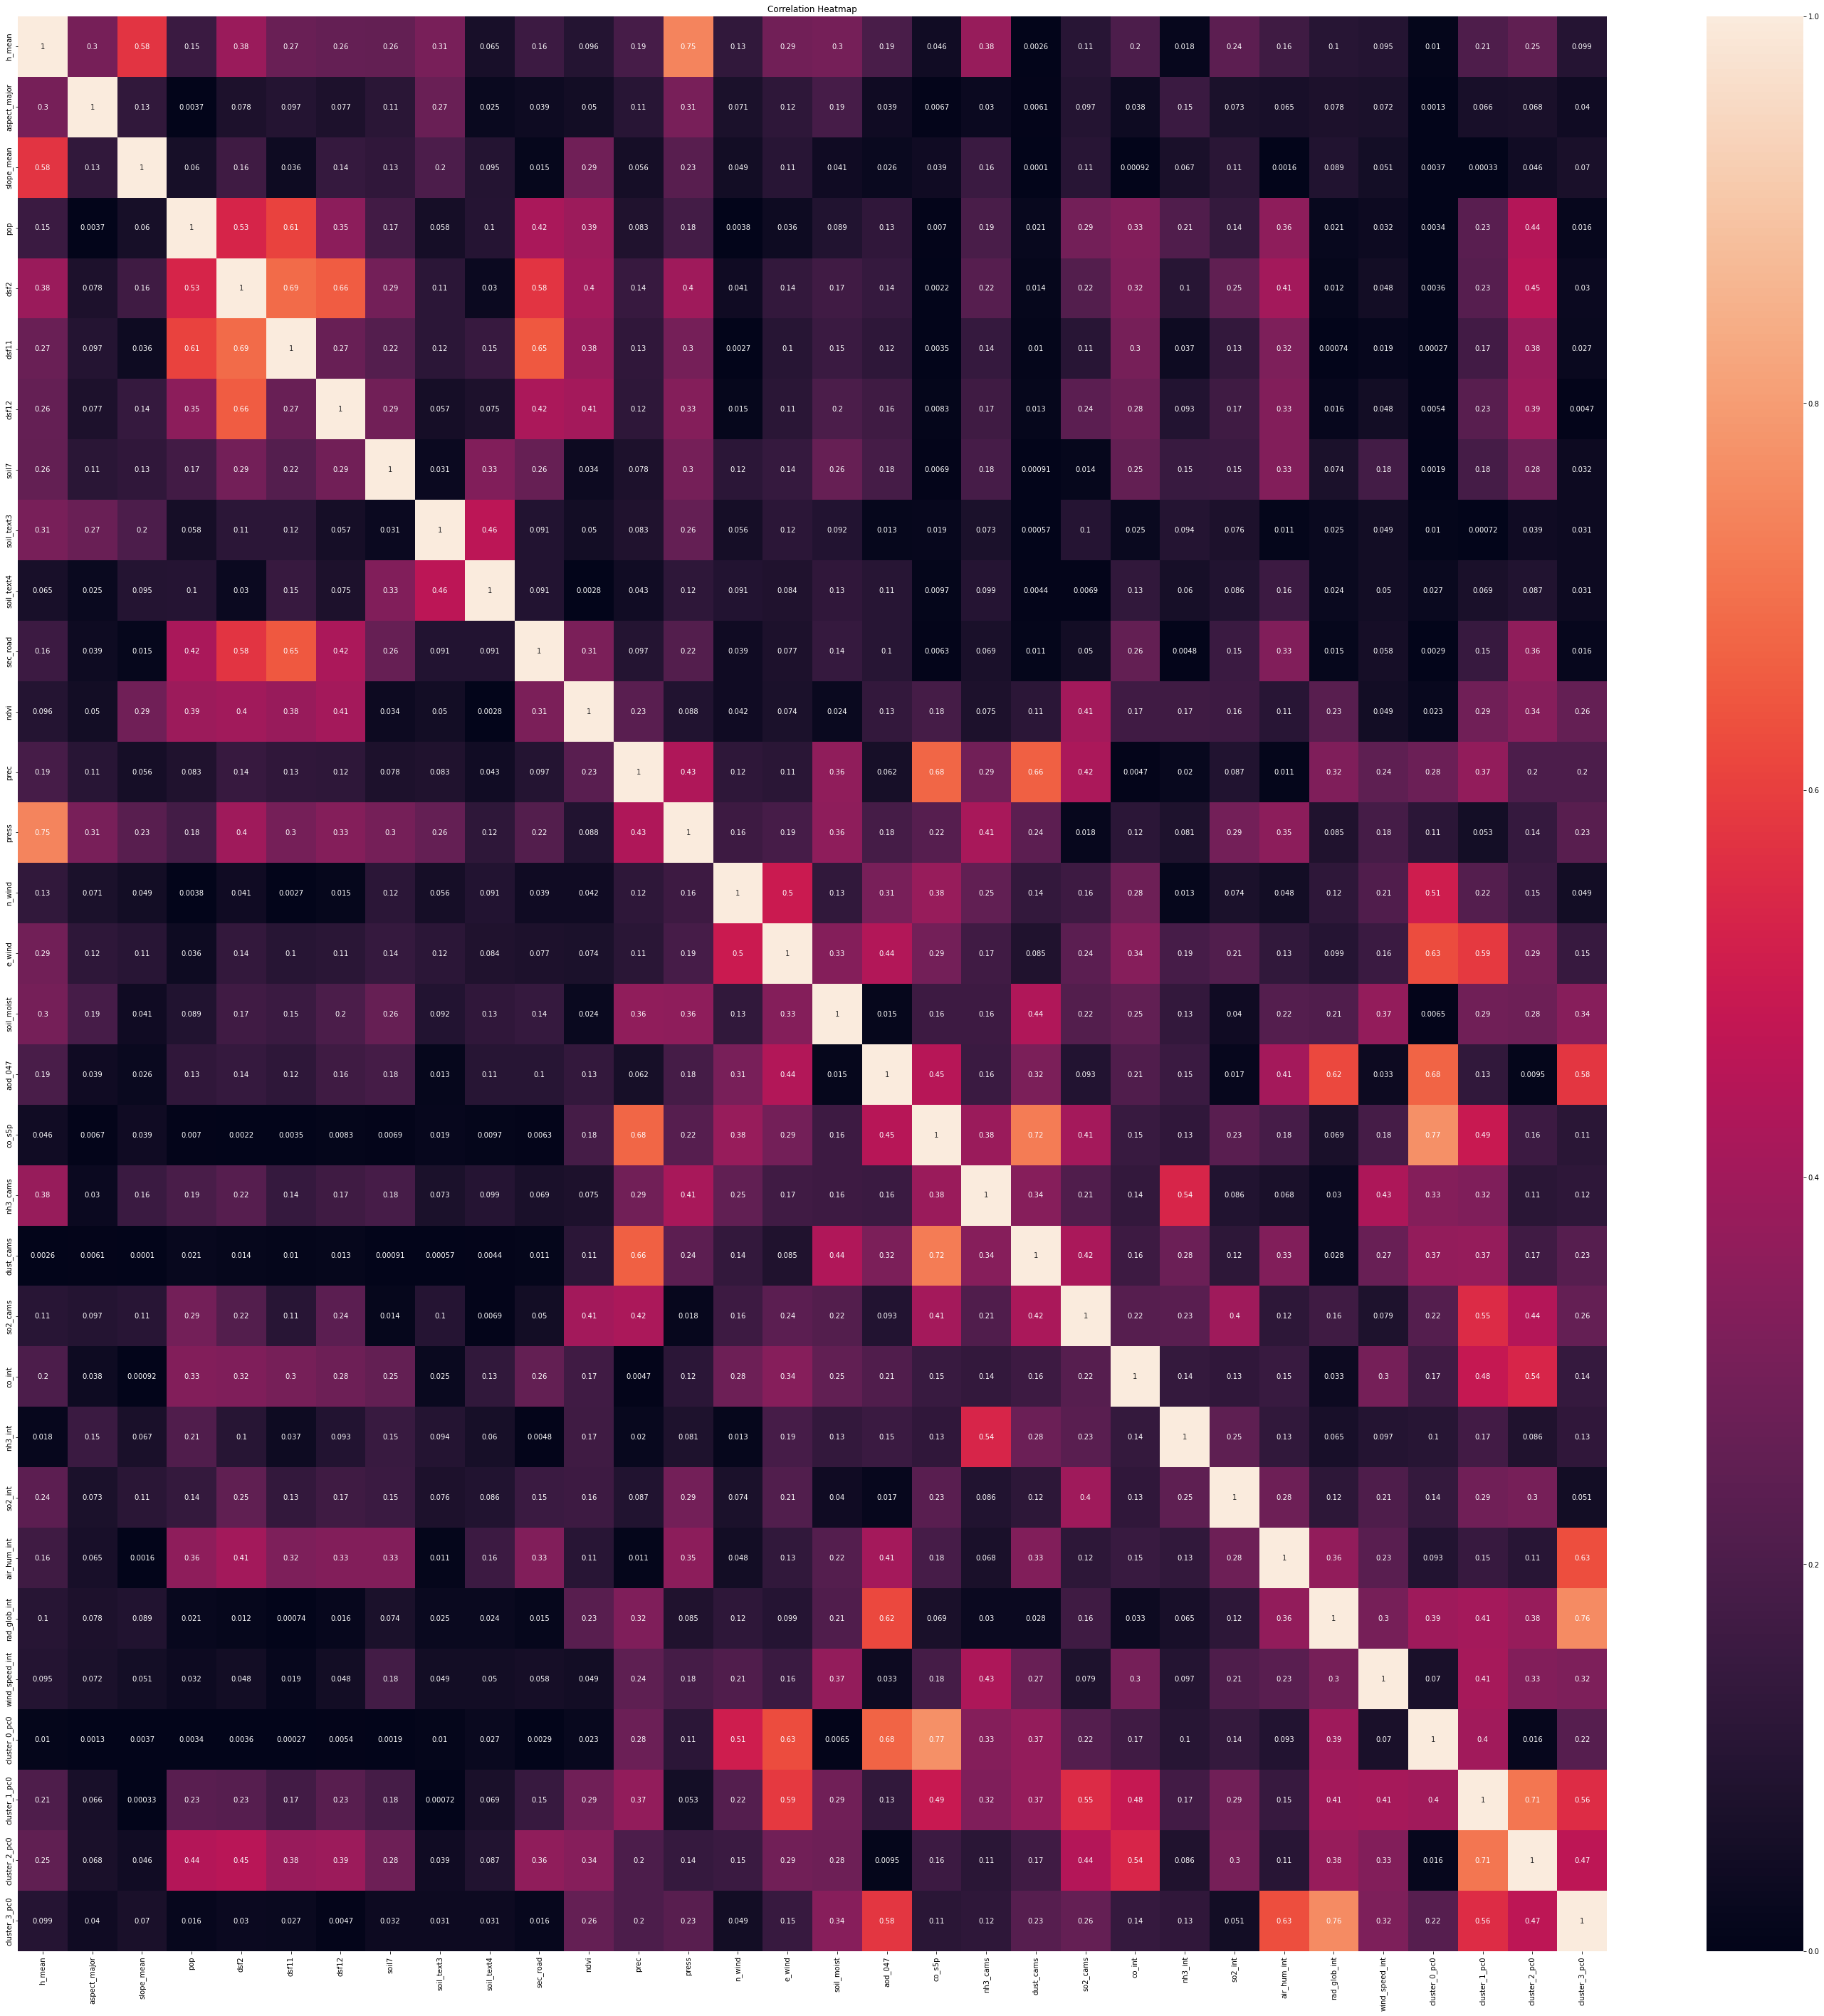

In [7]:
corr = X_new.corr().abs()
plt.figure(figsize=(50, 50))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})

In [8]:
print(X_new.shape)

'''
pca = PCA(n_components = X.shape[1])
pca_data = pca.fit_transform(X)
percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()
'''

(3185, 32)


'\npca = PCA(n_components = X.shape[1])\npca_data = pca.fit_transform(X)\npercent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))\ncumm_var_explained = np.cumsum(percent_var_explained)\n\nplt.plot(cumm_var_explained)\nplt.grid()\nplt.xlabel("n_components")\nplt.ylabel("% variance explained")\nplt.show()\n'

AttributeError: 'set' object has no attribute 'items'

<Figure size 432x288 with 0 Axes>

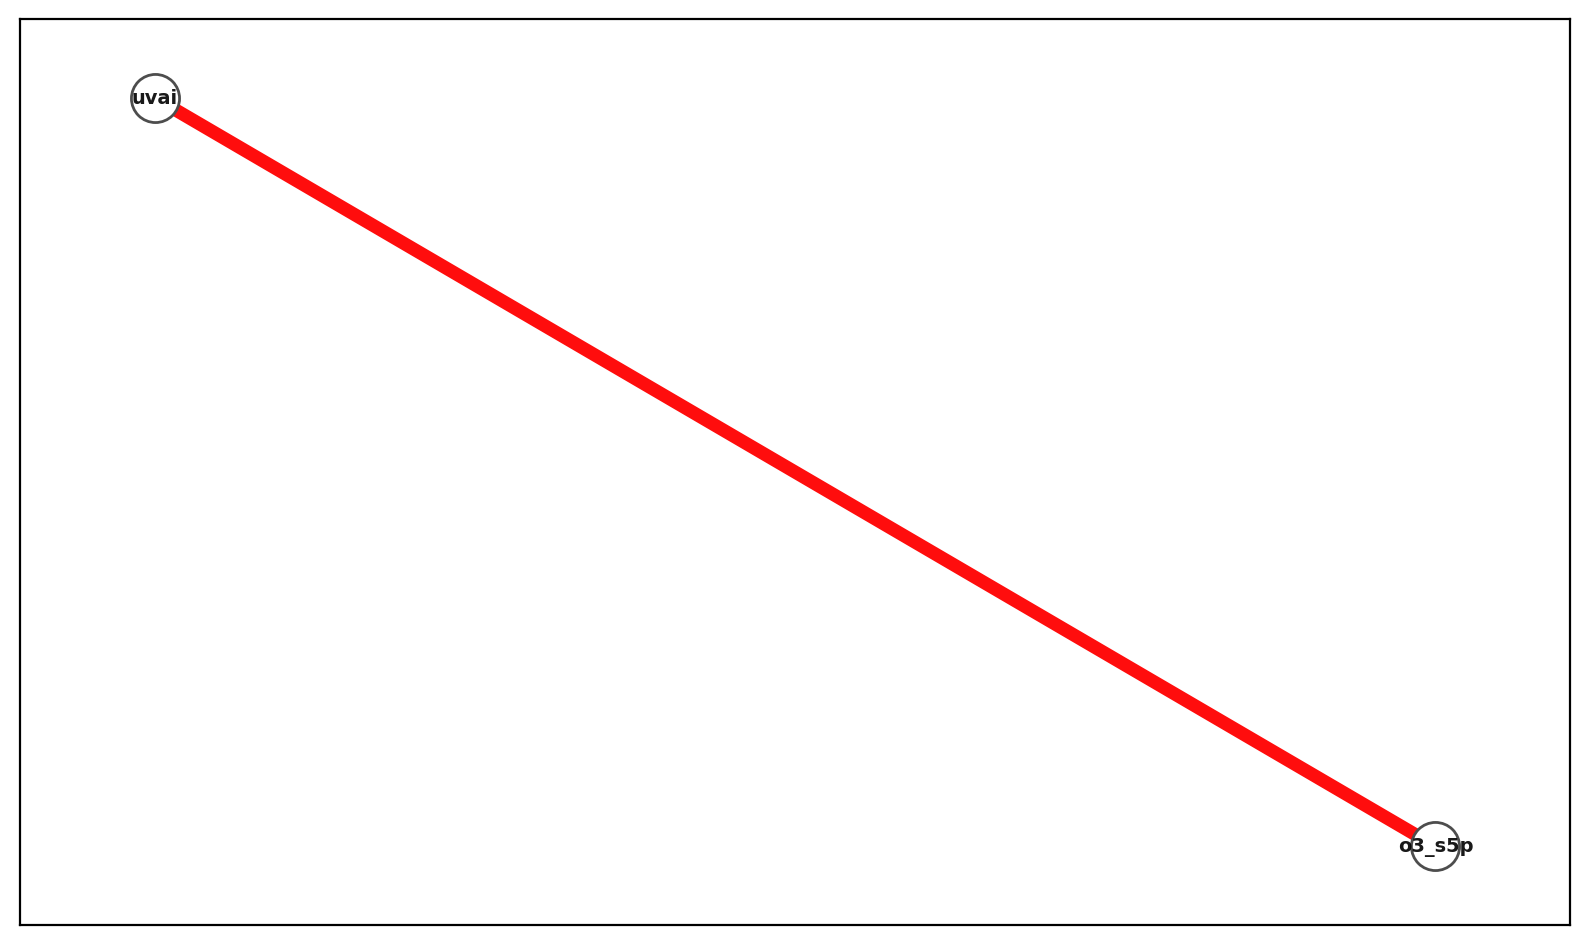

In [9]:
plt.figure()
for index, cl in enumerate(raw_data._clusters):
    cl.plot(fig_size = (10,6),dpi = 200, font_size = 7).savefig(cl.name+'.png')
    
'''
pca = PCA(n_components=40)
pca_train_data = pca.fit_transform(X_train)
pca_test_data = pca.transform(X_test)
df_train_pca = pd.DataFrame(pca_train_data)


corr = df_train_pca.corr().abs()
plt.figure(figsize = (80,80))

sns.heatmap(corr, annot = True, vmin=0, vmax=1, cmap="YlGnBu", linewidths=.5)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()
'''